In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pmf import pmf

Load dataset

In [2]:
anime_df = pd.read_csv('data/anime.csv')
anime_df = anime_df.rename(columns={'rating': 'avg_rating'})
rating_df = pd.read_csv('data/rating.csv')

In [3]:
rating_df = rating_df[rating_df['rating'] != -1]

combined_df = pd.merge(anime_df, rating_df, on='anime_id', how='inner')

uniq_users = combined_df['user_id'].unique()
uniq_animes = combined_df['anime_id'].unique()

n_users = len(uniq_users)
n_animes = len(uniq_animes)

df_copy = combined_df.copy()
train_set = df_copy.sample(frac=0.75, random_state=0)
test_set = df_copy.drop(train_set.index)

In [4]:
pmf_model = pmf(n_users=n_users, n_animes=n_animes, lambda_U=0.3, lambda_V=0.3, uniq_users=uniq_users, uniq_animes=uniq_animes)

In [ ]:
log_ps, rmse_train, rmse_test = pmf_model.train(train_set=train_set, test_set=test_set,n_epochs=10)

Log p a-posteriori at iteration 10 : -0.0


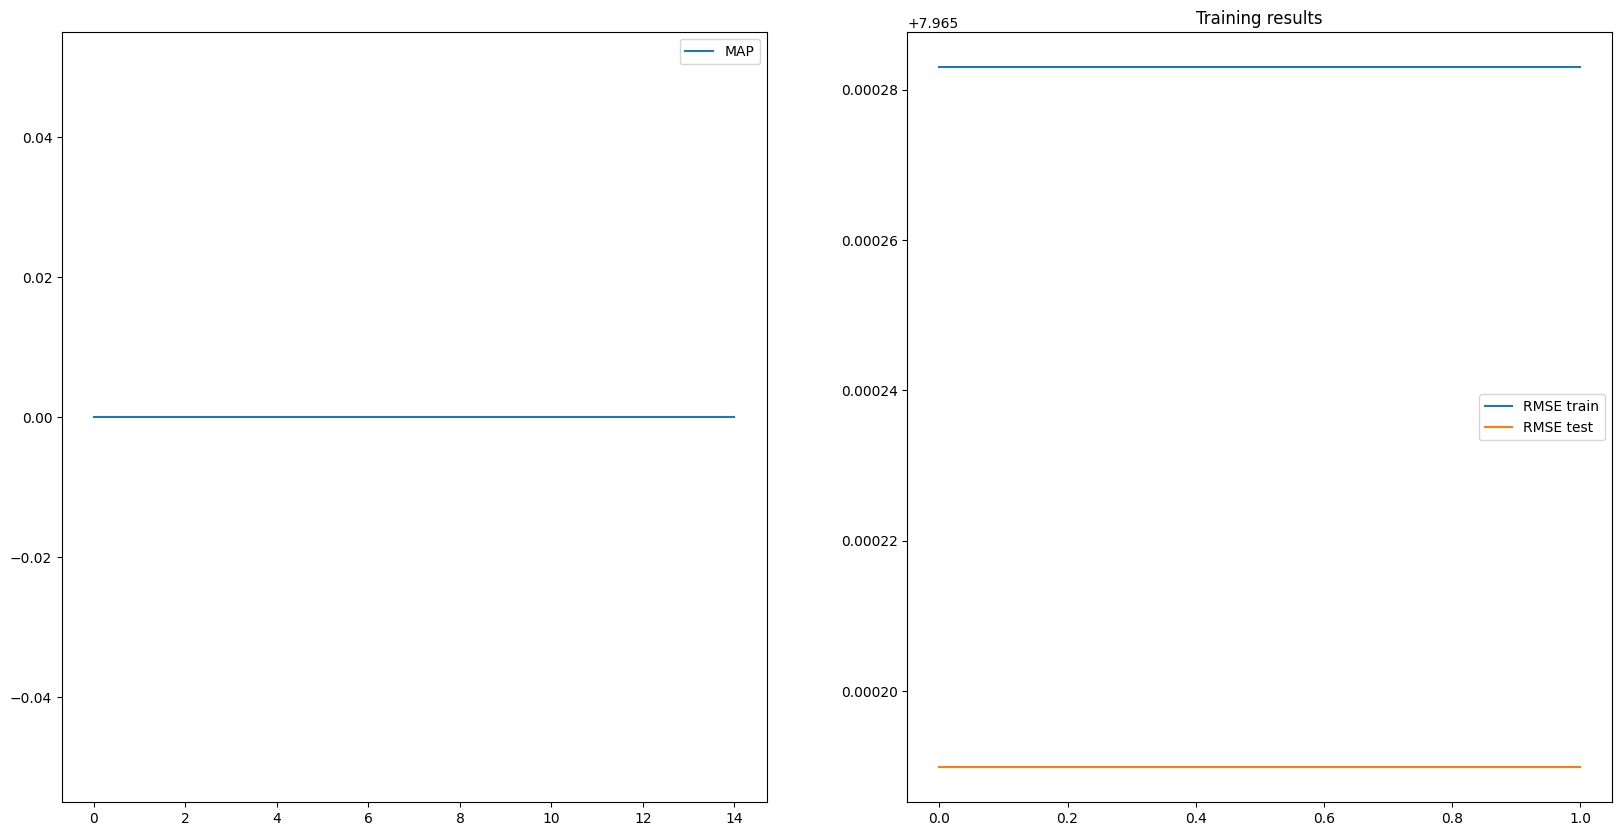

In [10]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
plt.title('Training results')
ax1.plot(np.arange(len(log_ps)), log_ps, label='MAP')
ax1.legend()

ax2.plot(np.arange(len(rmse_train)), rmse_train, label='RMSE train')
ax2.plot(np.arange(len(rmse_test)), rmse_test, label='RMSE test')
ax2.legend()

plt.show()

In [11]:
print('RMSE of training set:', pmf_model.evaluate(train_set))
print('RMSE of testing set:', pmf_model.evaluate(test_set))

RMSE of training set: 7.965283005472087
RMSE of testing set: 7.965189862590939
